In [1]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt

from itertools import count
from collections import namedtuple
from torch.autograd import Variable
from gridworld import GridworldEnv


# parser = argparse.ArgumentParser(description='PyTorch actor-critic example')
# parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
#                     help='discount factor (default: 0.99)')
# parser.add_argument('--seed', type=int, default=543, metavar='N',
#                     help='random seed (default: 1)')
# parser.add_argument('--render', action='store_true',
#                     help='render the environment')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='interval between training status logs (default: 10)')
# args = parser.parse_args()

gamma_rl = 0.99

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
env = GridworldEnv(shape=(5, 5))

In [4]:
# env = gym.make('MountainCar-v0')
# env.seed(args["seed"])
# torch.manual_seed(args["seed"])

In [5]:
def entropy_term(probs):
    return -torch.sum(probs * torch.log(probs))

In [6]:
#state_dim = 2 * len(env.state)
state_dim = int(env.nS * 2)
action_dim = int(env.nA)

hidden_layer1_size = 50
hidden_layer2_size = 50

lambda_baseline = 0.1

entropy_weights = {
    "Alice":0.0,
    "Bob":0.00,
}

eps = 1e-3

In [7]:
SavedAction = namedtuple('SavedAction', ['action', 'prob', 'value'])
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(state_dim, hidden_layer1_size)
        nn.init.xavier_normal(self.affine1.weight)
        self.action_head = nn.Linear(hidden_layer2_size, action_dim)
        nn.init.xavier_normal(self.action_head.weight)
        self.value_head = nn.Linear(hidden_layer2_size, 1)
        nn.init.xavier_normal(self.value_head.weight)

        self.saved_actions = []
        self.rewards = []

    def forward(self, s, s_star=None):
        x_onehot = torch.zeros((1, state_dim))
        x_onehot[0][s] = 1
        if(not (s_star is None)):
            x_onehot[0][state_dim // 2 + s_star] = 1
        x_onehot = Variable(x_onehot)
        x = F.relu(self.affine1(x_onehot))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores), state_values

In [8]:
def select_action(state, s_star, model):
    #state = torch.from_numpy(state).int().unsqueeze(0)
    probs, state_value = model(state, s_star)
    action = probs.multinomial()
    model.saved_actions.append(SavedAction(action, probs, state_value))
    return action.data

In [9]:
def update_params(model, optimizer, who="Alice"):
    R = 0
    saved_actions = model.saved_actions
    value_loss = 0
    entropy_loss = 0
    rewards = []
    for r in model.rewards[::-1]:
        R = r + gamma_rl * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    for (action, probs, value), r in zip(saved_actions, rewards):
        reward = r - value.data[0, 0]
        action.reinforce(reward)
        value_loss += lambda_baseline * F.mse_loss(value, Variable(torch.Tensor([r])))
        entropy_loss += -entropy_weights[who] * entropy_term(probs)

    optimizer.zero_grad()
    final_nodes = [value_loss] + [entropy_loss] + list(map(lambda p: p.action, saved_actions))
    gradients = [torch.ones(1)] + [torch.ones(1)] + [None] * len(saved_actions)
    
    autograd.backward(final_nodes, gradients)
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]


In [10]:
def check_equivalence(s1, s2, eps=1e-9):
    return np.sum((s1 - s2) ** 2) < eps
    

In [11]:
def set_random_s0(env):
    rand_s0 = np.random.randint(12, 13)
    #rand_s0 = np.random.randint(0, env.nS)
    
    for i in range(len(env.isd)):
        env.isd[i] = 0
    
    env.isd[rand_s0] = 1
    

In [12]:
def self_play_episode(env, tmax, model_Alice, model_Bob, pretraining_type="Repeat", is_gridworld=True):
    
    if(pretraining_type == "Repeat" and is_gridworld):
        set_random_s0(env)
    
    s0 = env.reset()
    if pretraining_type == "Reverse":
        s_star = s0
    #Alice term
    tA = 0
    done = False
    while True:
        tA = tA + 1
        #s = np.concatenate(([env.s], [s0]), axis=0).flatten()
        a = select_action(env.s, s0, model_Alice)
        if a[0,0] == env.action_space.n or tA >= tmax:
            if(pretraining_type == "Repeat"):
                s_star = env.s
                env.reset()
            
            break
        state, _, done, _= env.step(a[0, 0])
        model_Alice.rewards.append(0)
    
    #Bob term
    tB = 0
    done = False
    while True:
        if check_equivalence(np.array(env.s), np.array(s_star))  or (tB + tA >= tmax):
            break
        tB += 1
        a = select_action(env.s, s_star, model_Bob)
        state, _, done, _= env.step(a[0, 0])
        model_Bob.rewards.append(0)
    
    R_Alice = gamma * max(0, tB - tA)
    model_Alice.rewards.append(R_Alice)
    R_Bob = -gamma * tB
    if(len(model_Bob.saved_actions)):
        if(len(model_Bob.rewards)):
            model_Bob.rewards[-1] = R_Bob
        else:
            model_Bob.rewards.append(R_Bob)
    
    if(len(model_Bob.saved_actions)):
        update_params(model_Bob, optimizer_Bob, "Bob")
    if(len(model_Alice.saved_actions)):
        update_params(model_Alice, optimizer_Alice, "Alice")
    
    return (R_Alice, R_Bob), (tA, tB), (s_star, env.s)
    

In [13]:
lr_Alice = 1e-2
lr_Bob = 1e-2

gamma = 0.1

In [14]:
model_Alice = Policy(state_dim, action_dim + 1)
model_Bob = Policy(state_dim, action_dim)

#optimizer_Alice = optim.SGD(model_Alice.parameters(), lr=lr_Alice)
#optimizer_Bob = optim.SGD(model_Bob.parameters(), lr=lr_Bob)

optimizer_Alice = optim.RMSprop(model_Alice.parameters(), alpha=0.97, eps=1e-6, lr=lr_Alice)
optimizer_Bob = optim.RMSprop(model_Bob.parameters(), alpha=0.97, eps=1e-6, lr=lr_Bob)

In [15]:
from tqdm import tnrange

def pretrain_model(env, tmax, model_Alice, model_Bob, episodes, pretraining_type="Repeat"):
    rewards = []
    episode_time = []
    finish_states = []
    for i in range(episodes):
        #print("Episode %d:" % (i + 1))
        res = self_play_episode(env, tmax, model_Alice, model_Bob, pretraining_type)
        if(i % (episodes // 100) == 0):     
            rewards.append(res[0])
            episode_time.append(res[1])
            finish_states.append(res[2])
            
    
    return model_Alice, model_Bob, np.array(rewards), np.array(episode_time), np.array(finish_states)

In [16]:
import copy
model_Bob_old = copy.deepcopy(model_Bob)
model_Alice_old = copy.deepcopy(model_Alice)

In [71]:
#model_Bob, rewards, time, finish_states = pretrain_model(env, 40, model_Alice, model_Bob, int(1e4), pretraining_type="Repeat")

In [72]:
plots_dir = "plots_pretrain/without_entropy_middle_init"

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/andrejklimkin/anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/andrejklimkin/anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


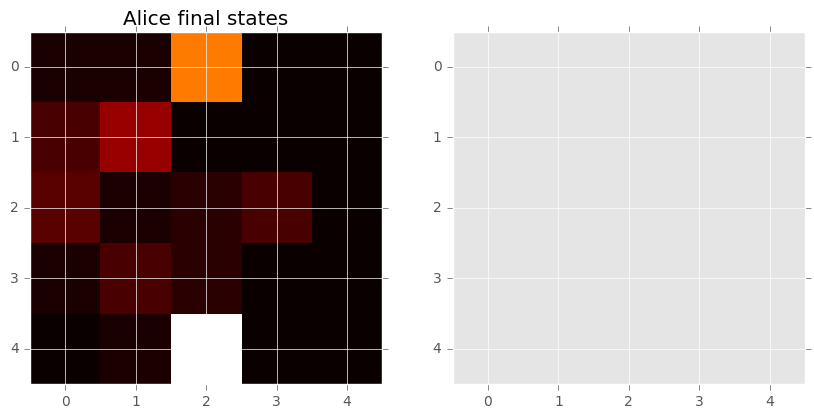

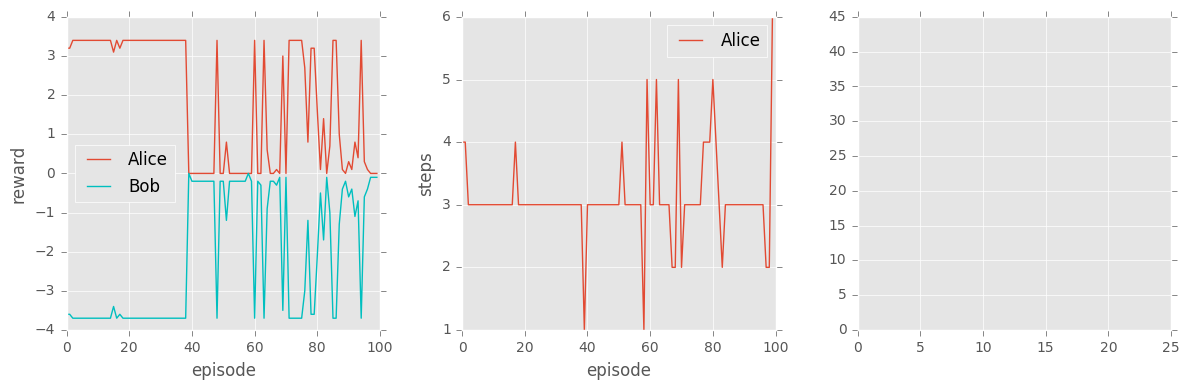

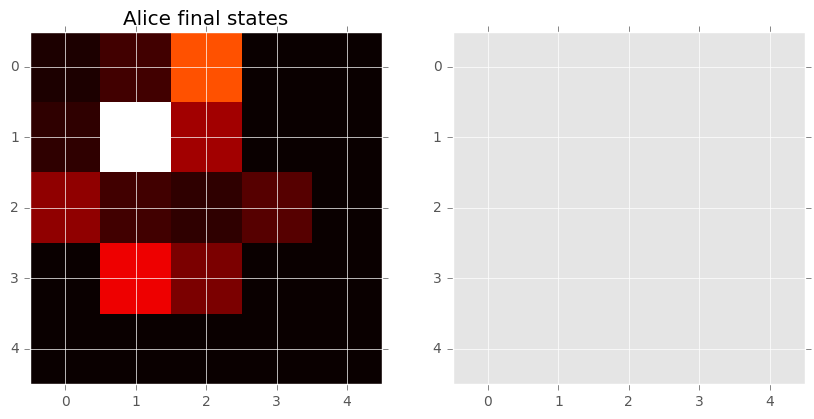

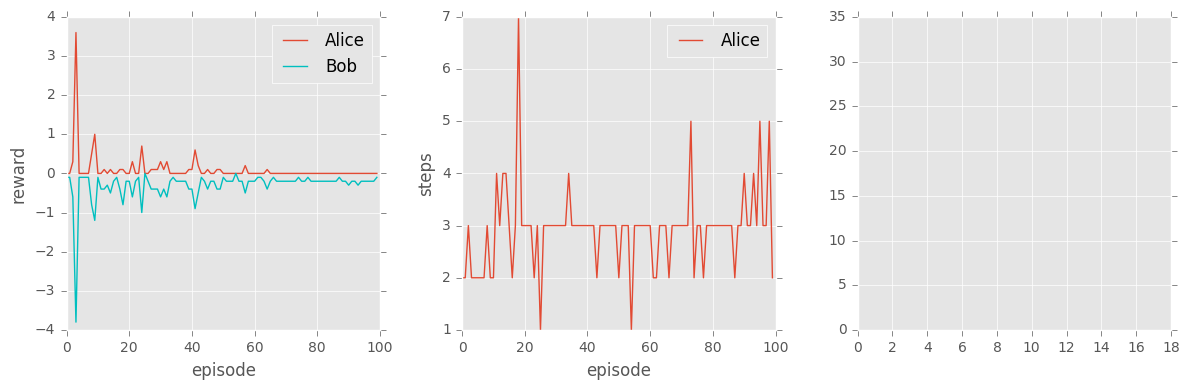

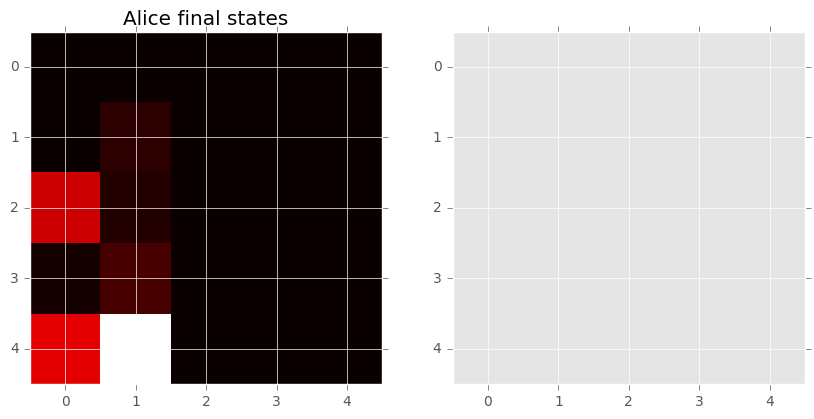

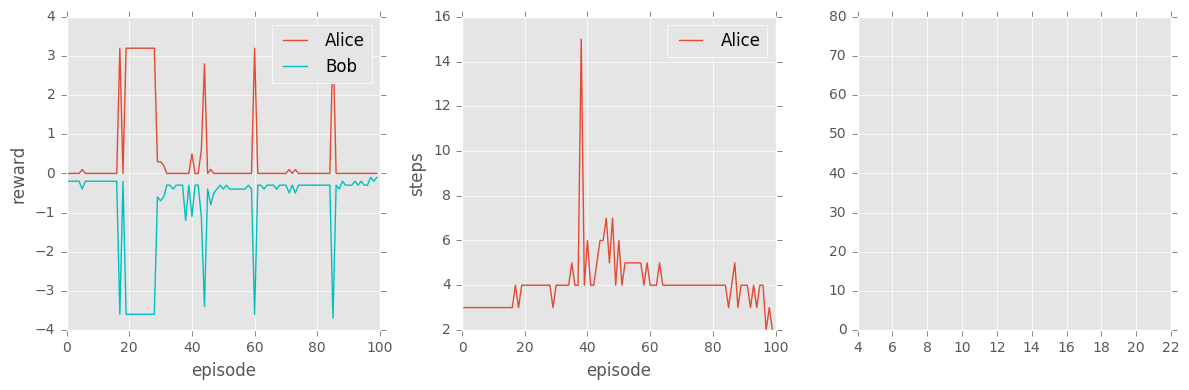

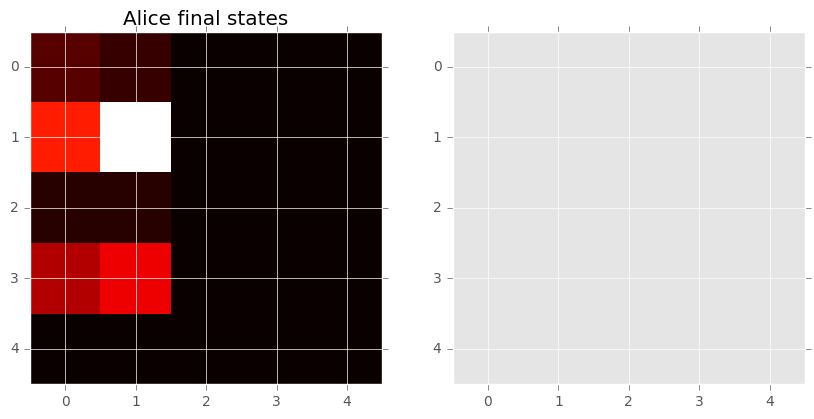

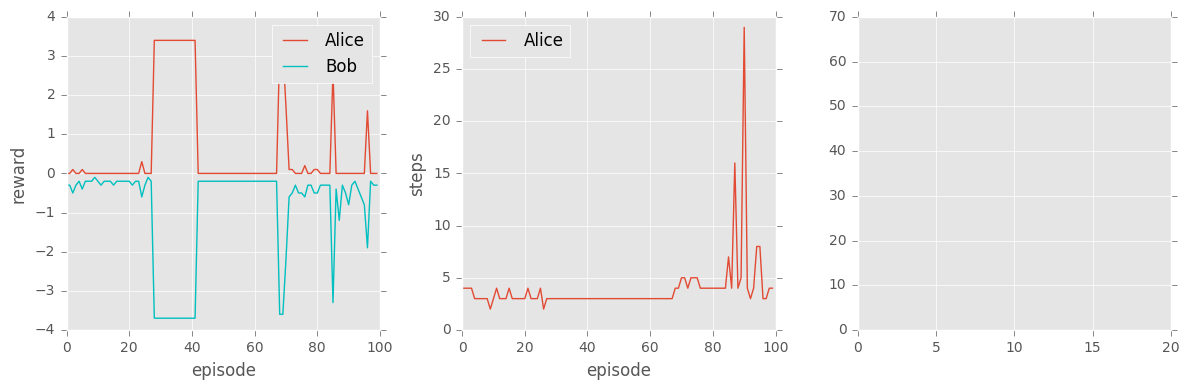

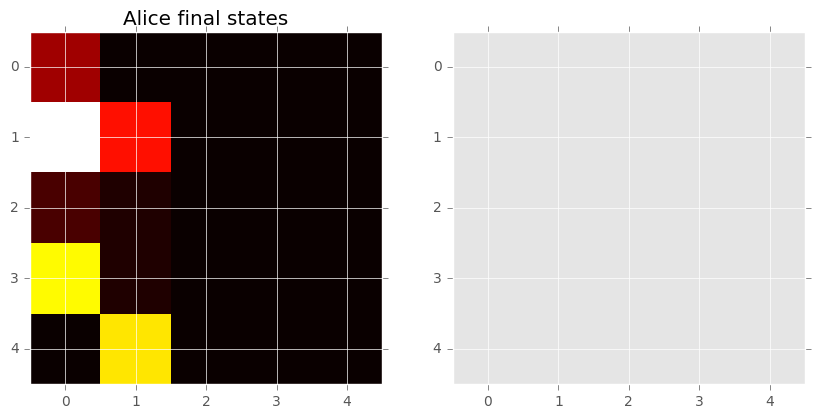

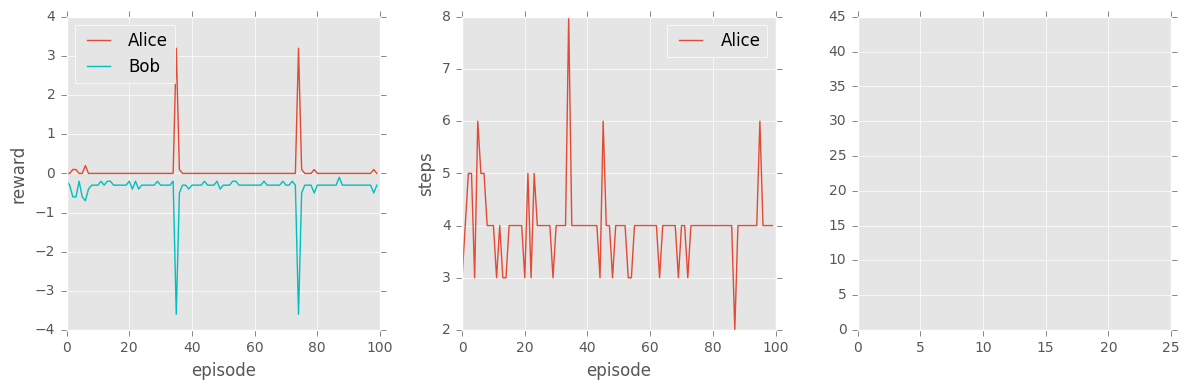

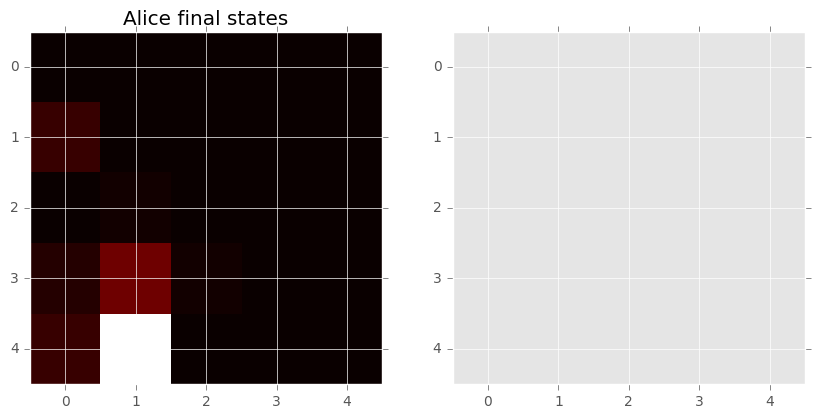

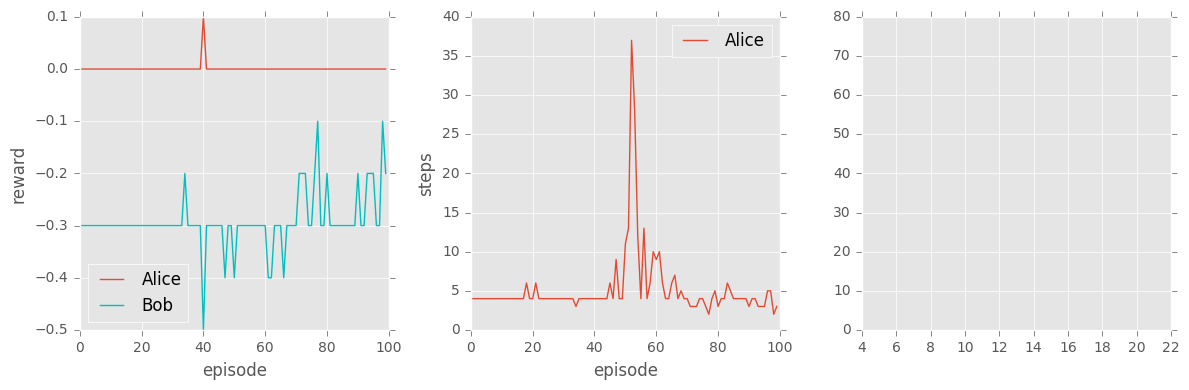

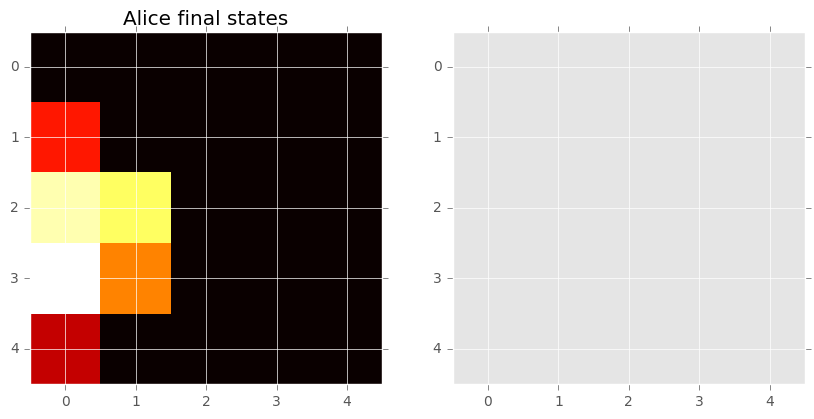

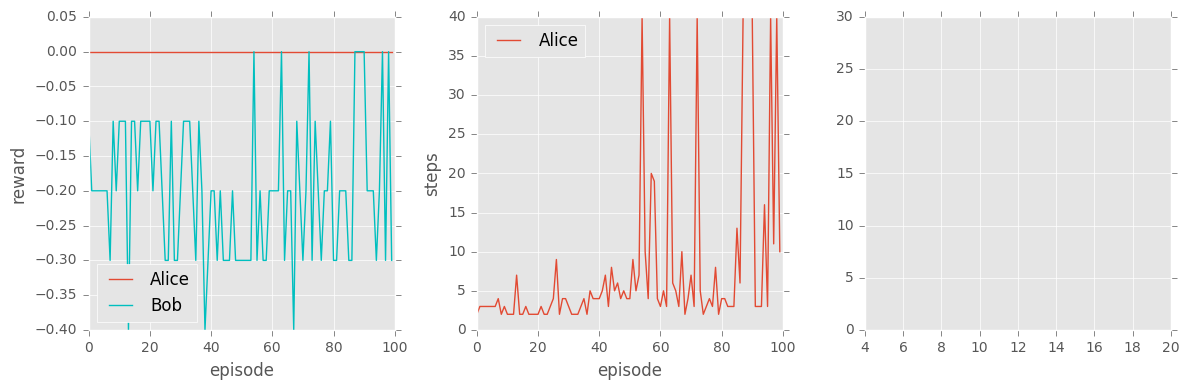

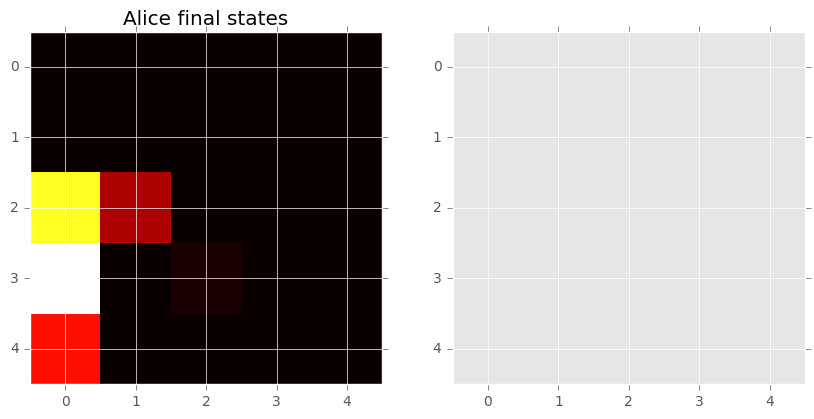

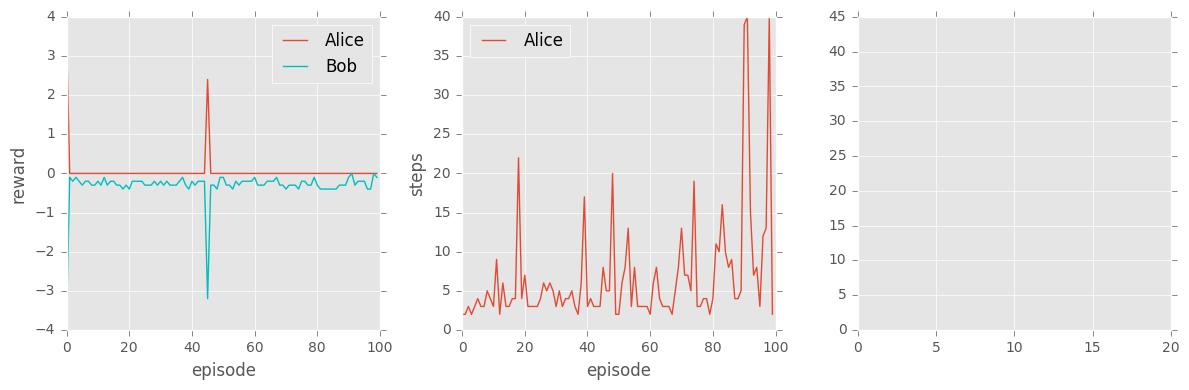

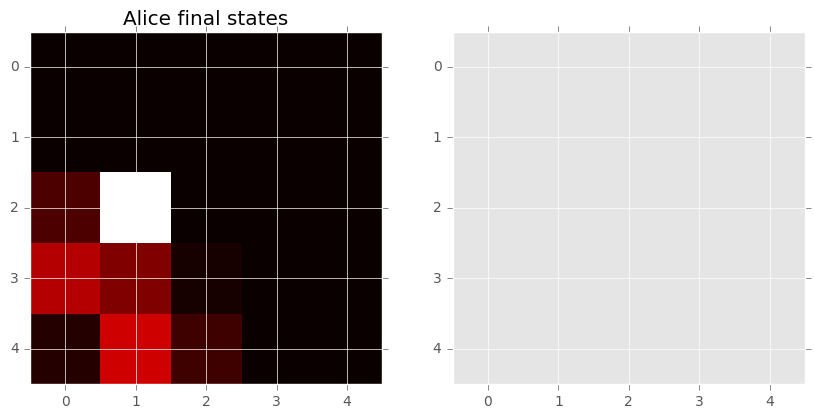

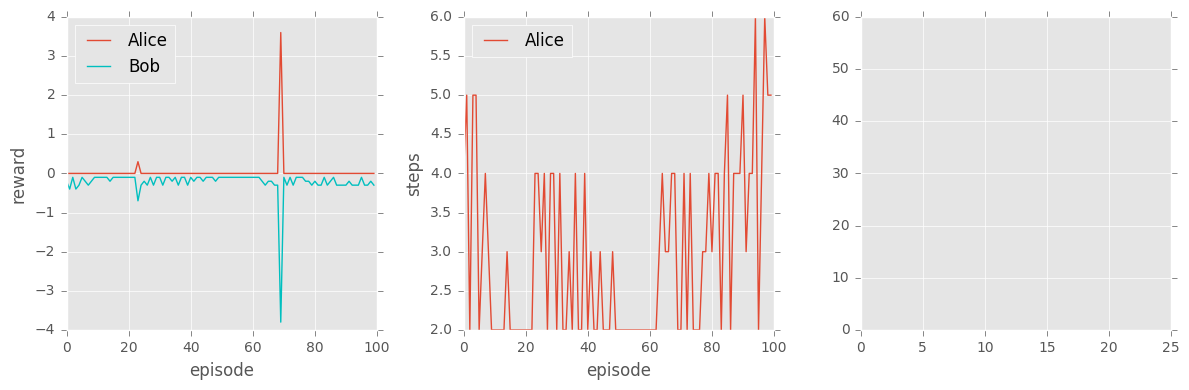

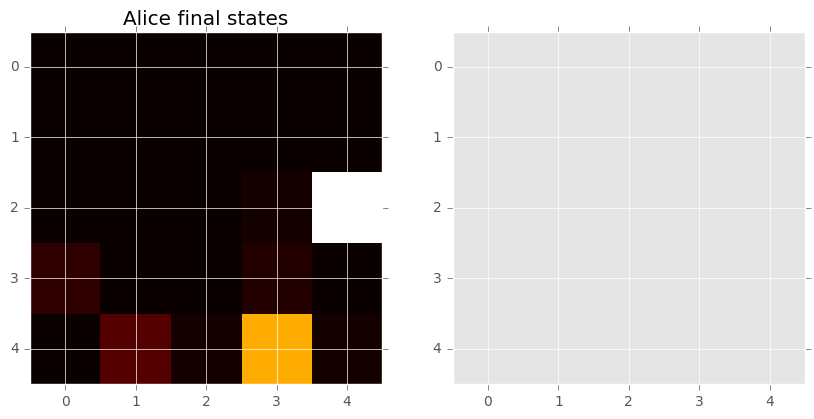

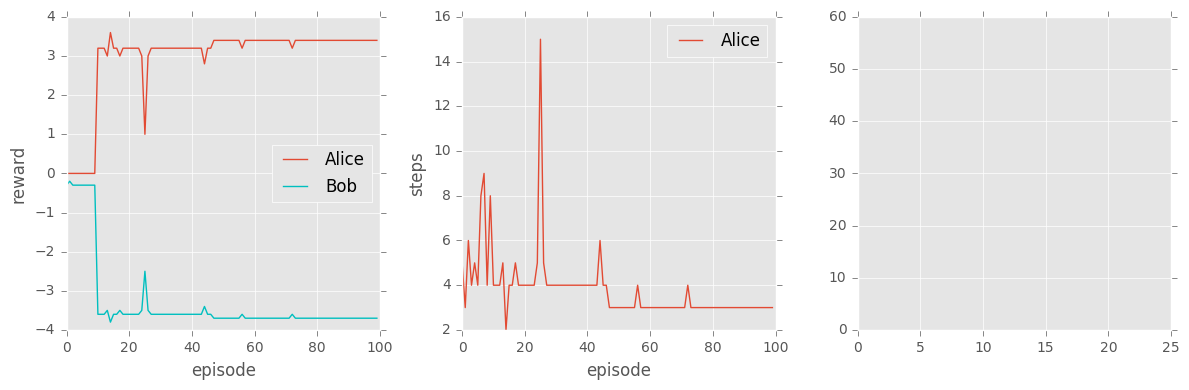

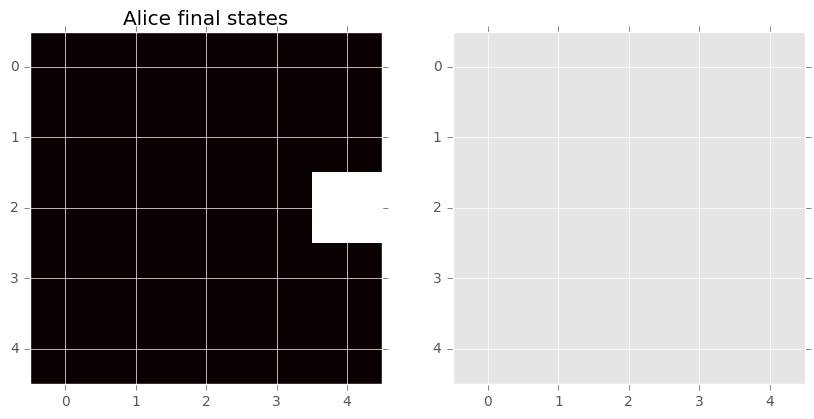

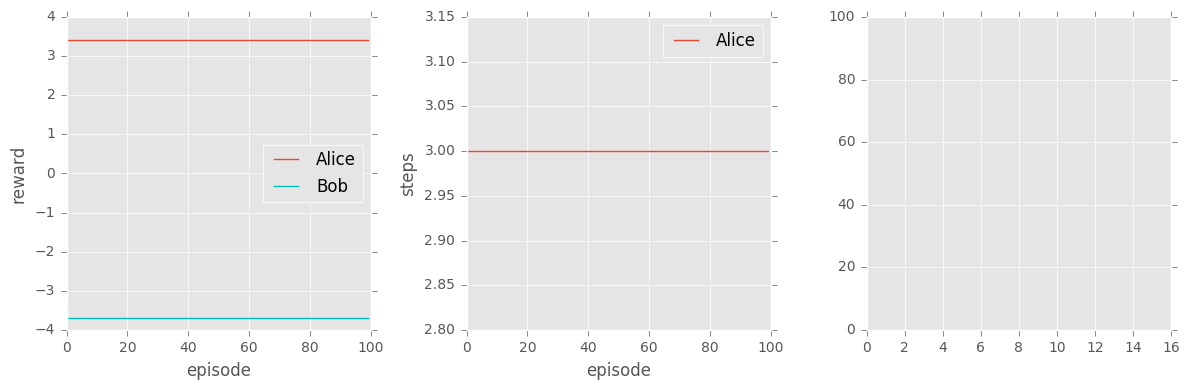

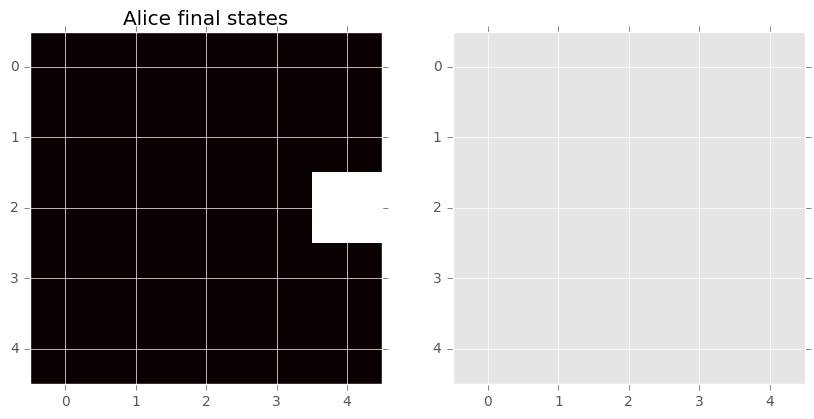

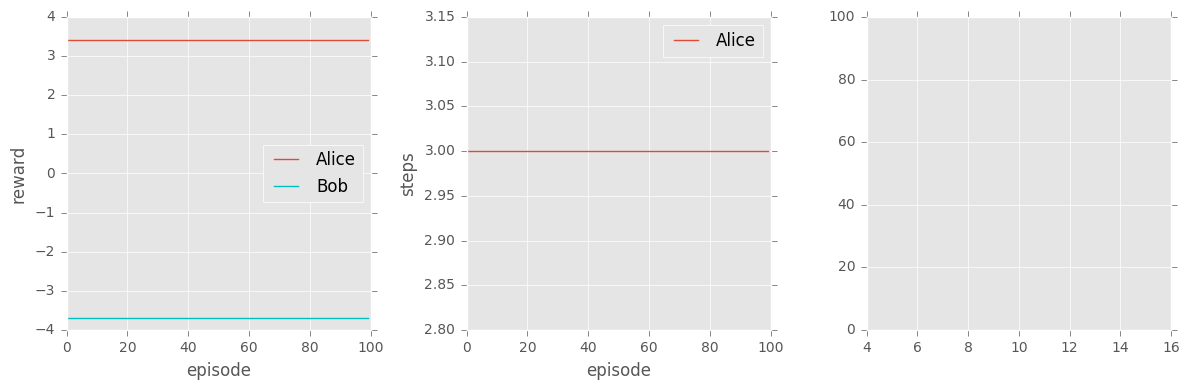

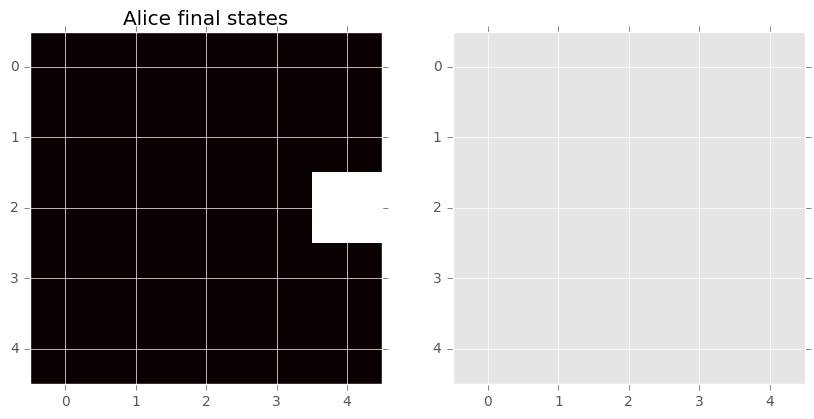

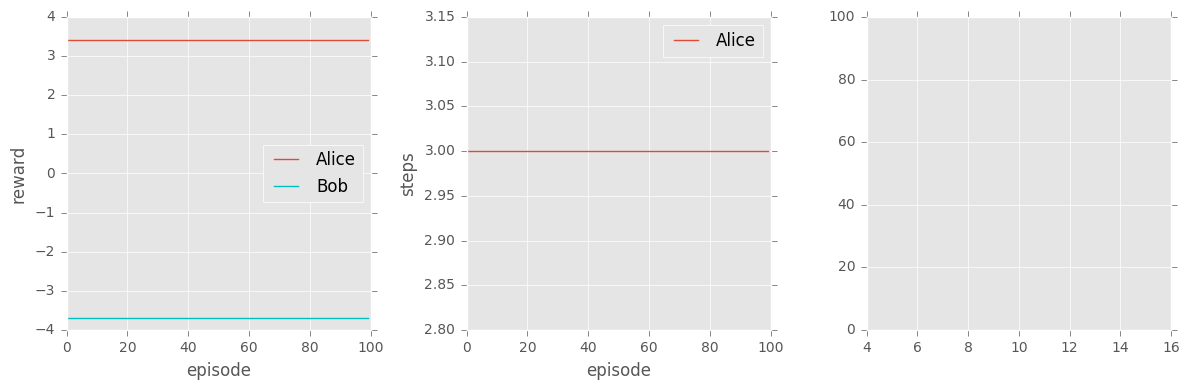

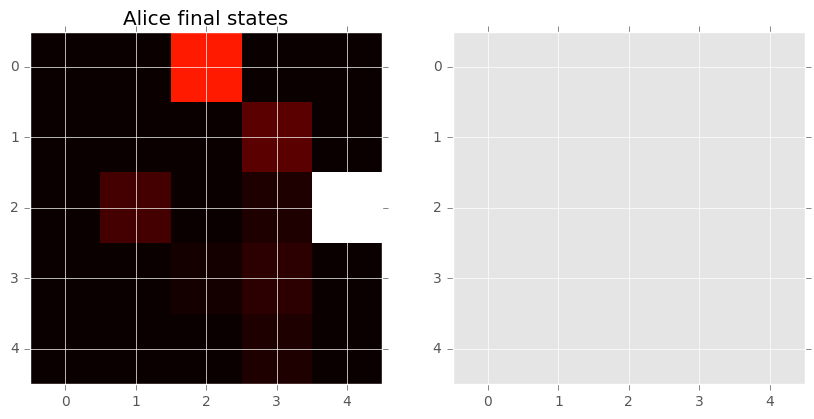

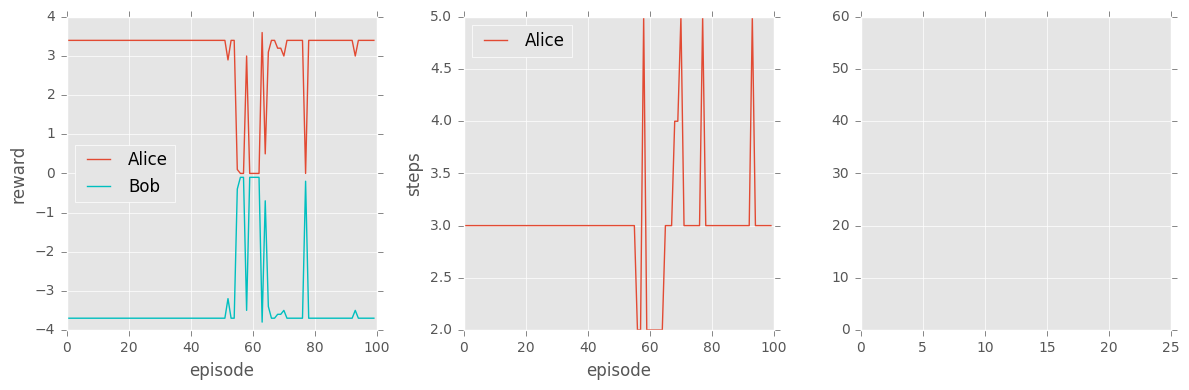

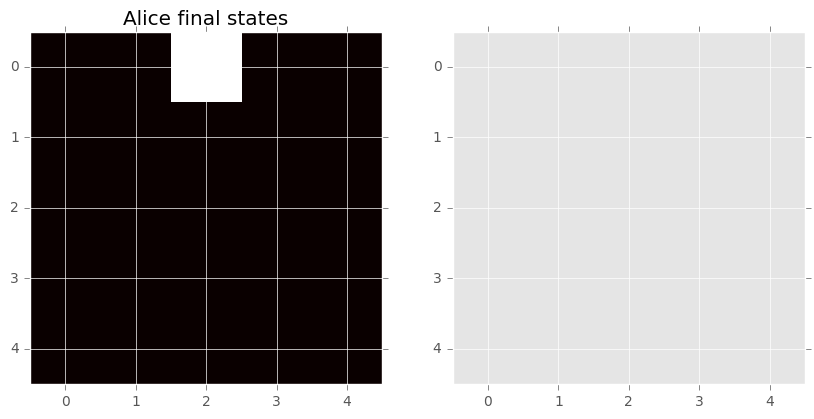

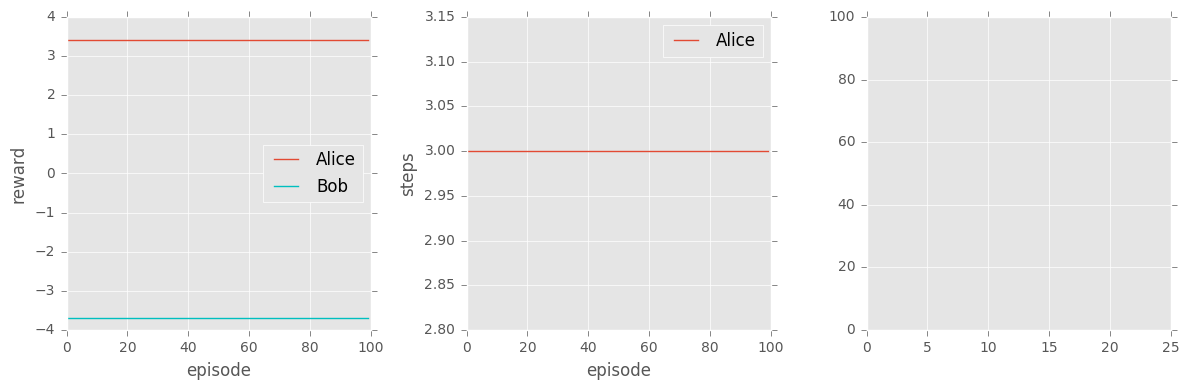

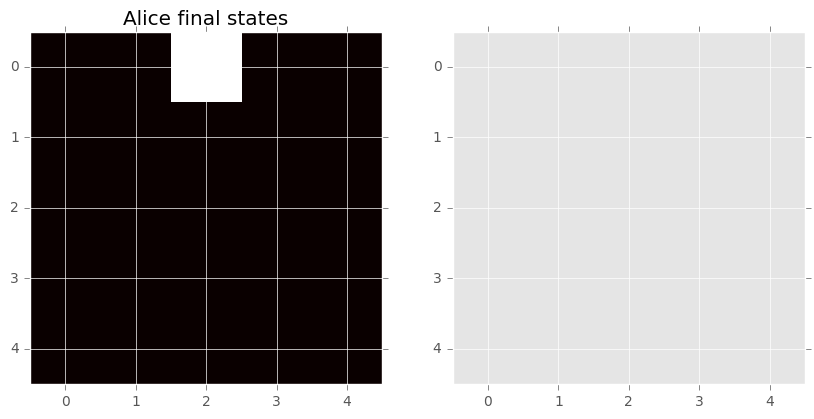

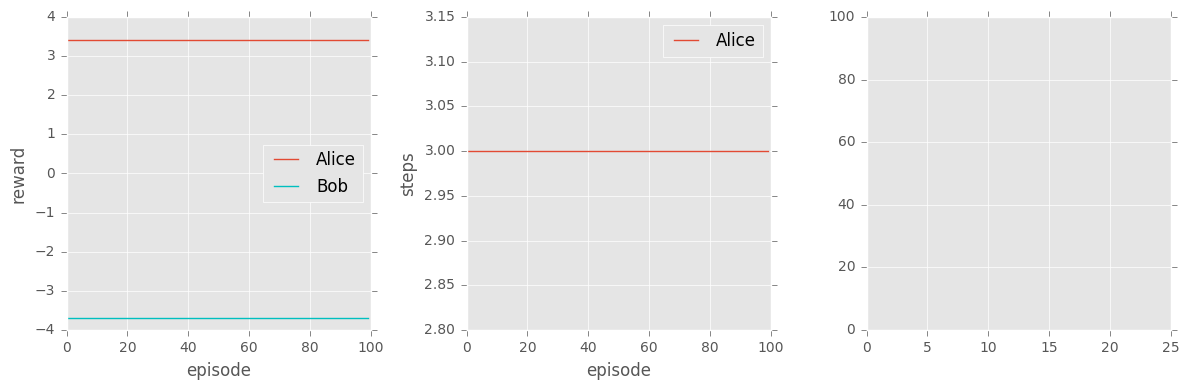

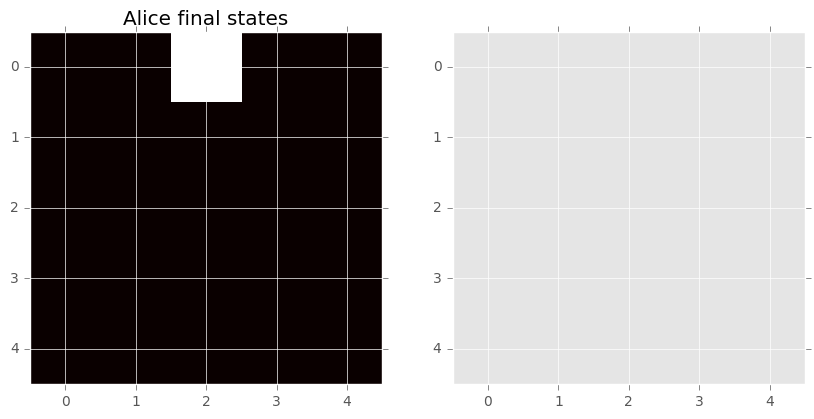

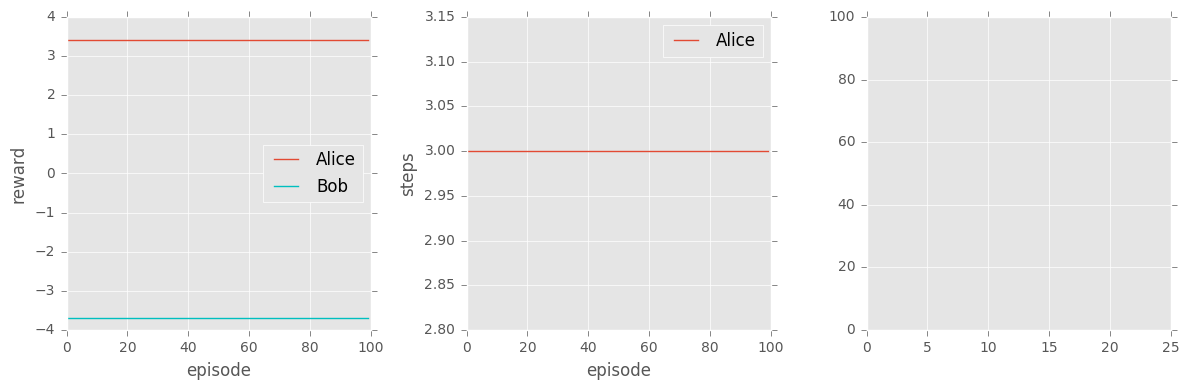

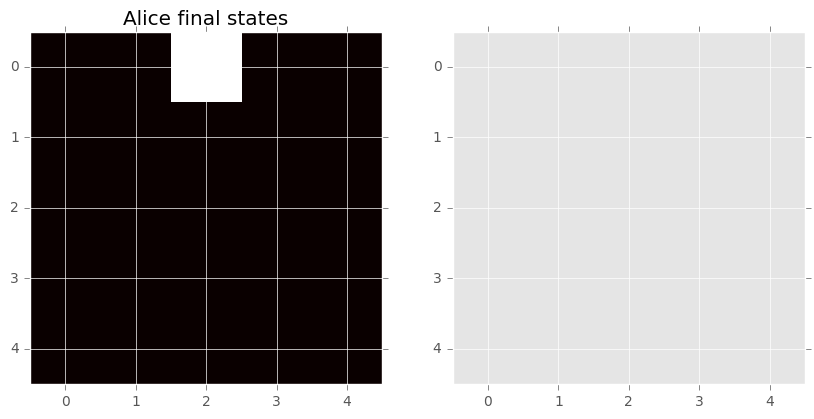

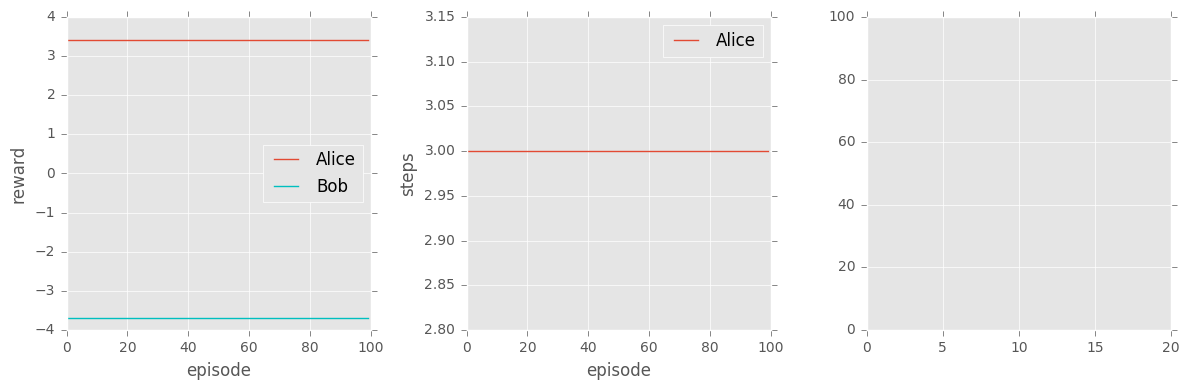

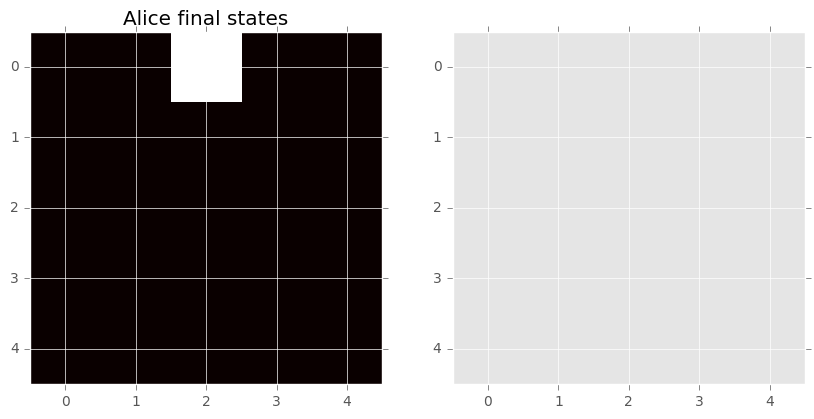

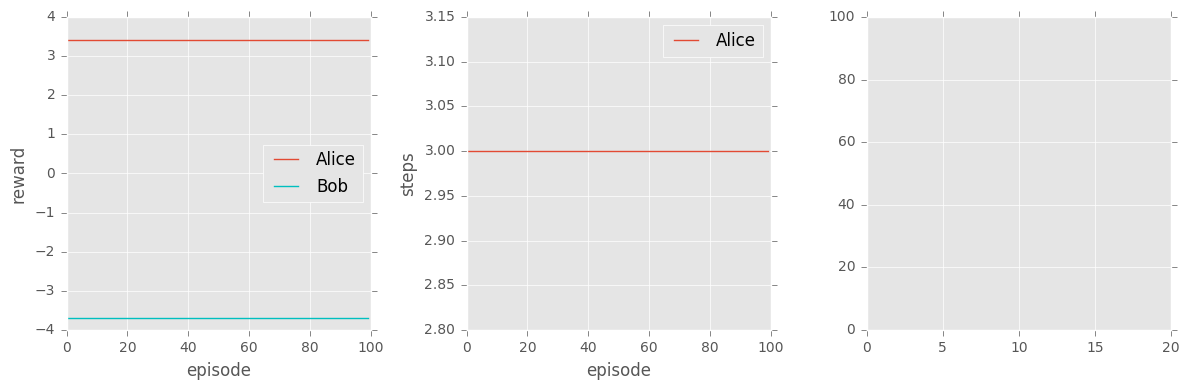

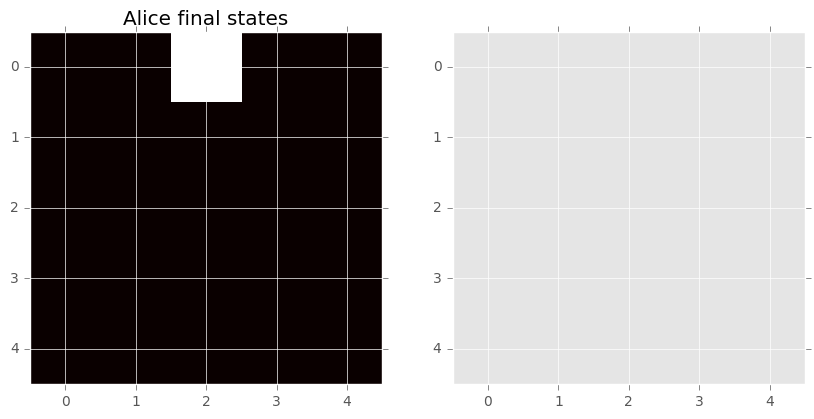

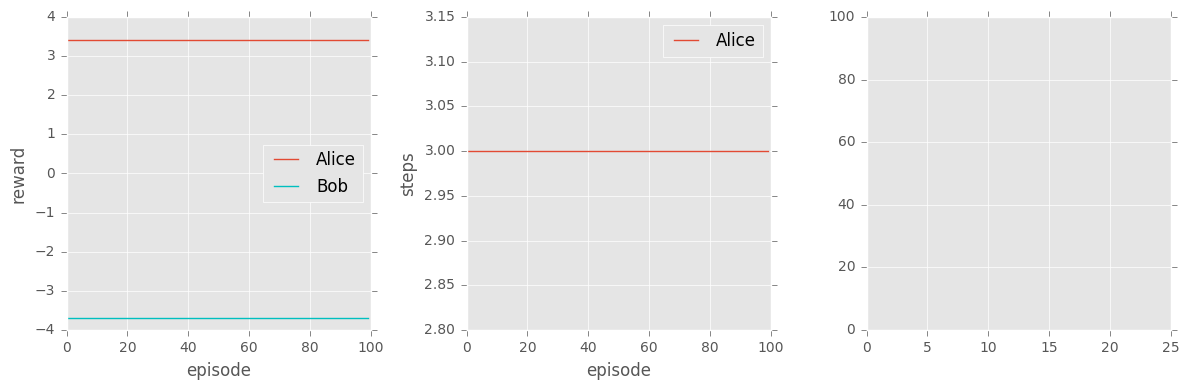

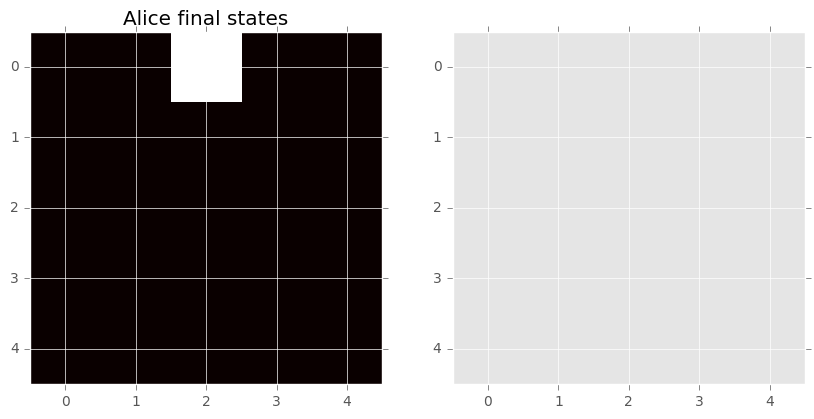

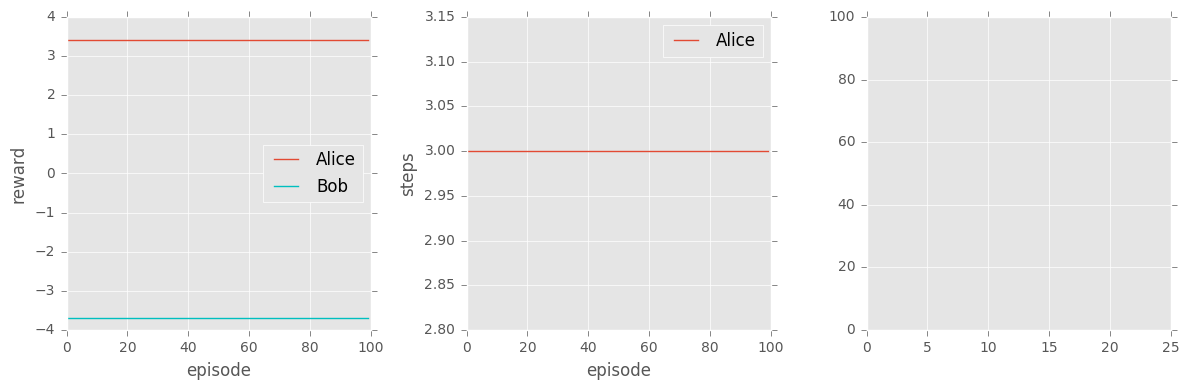

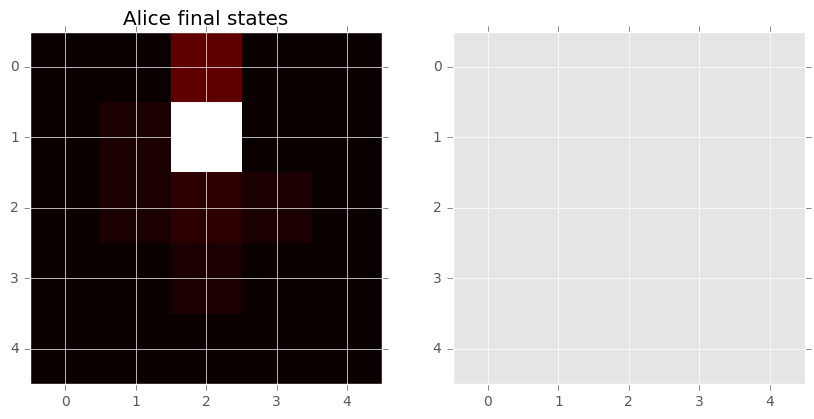

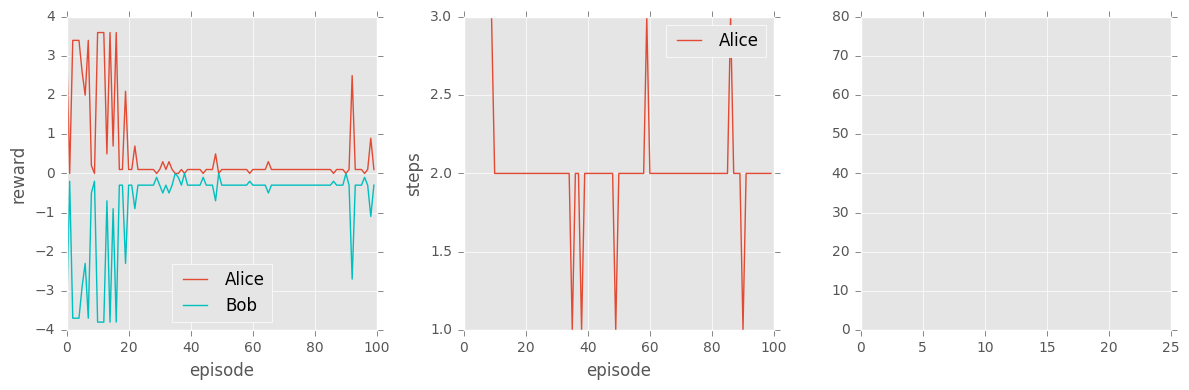

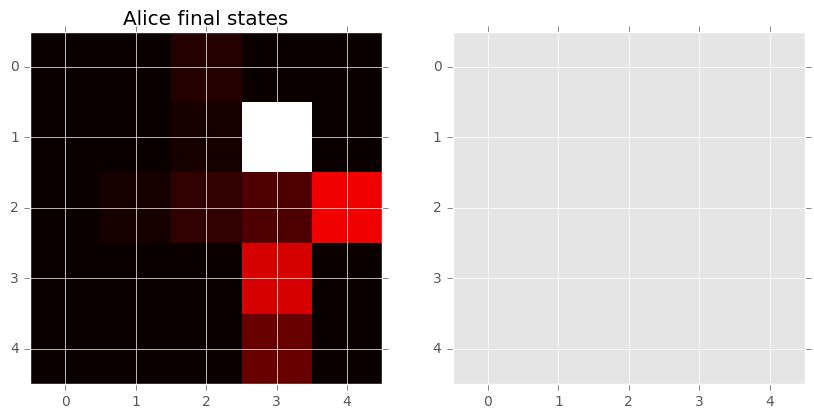

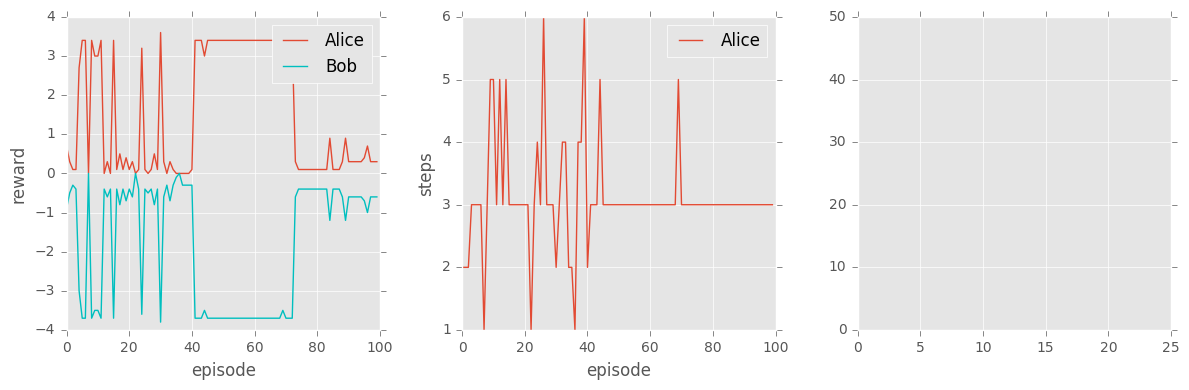

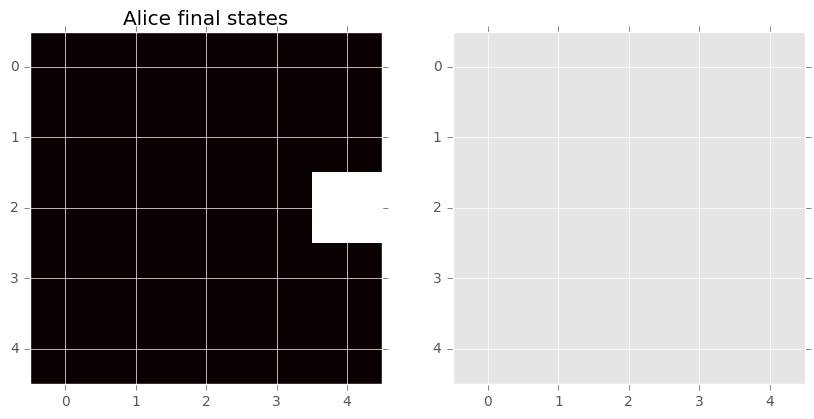

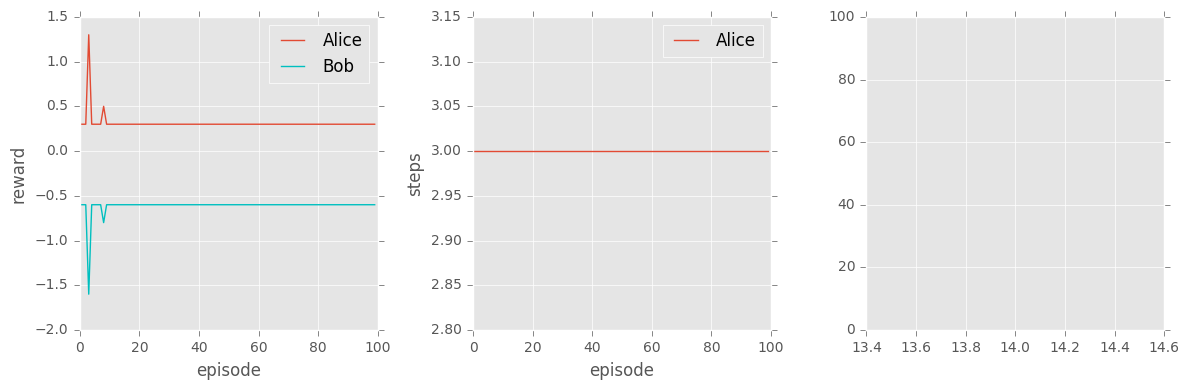

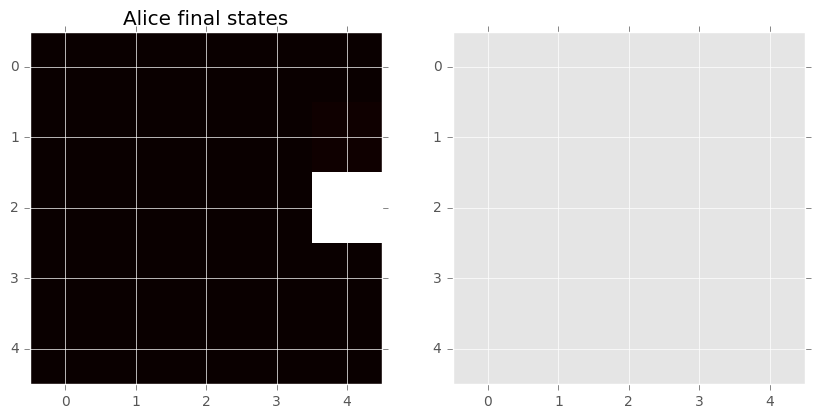

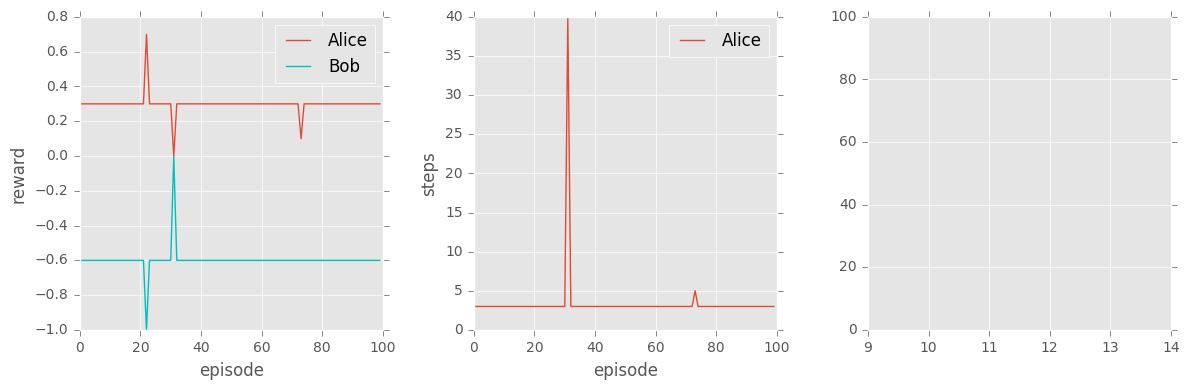

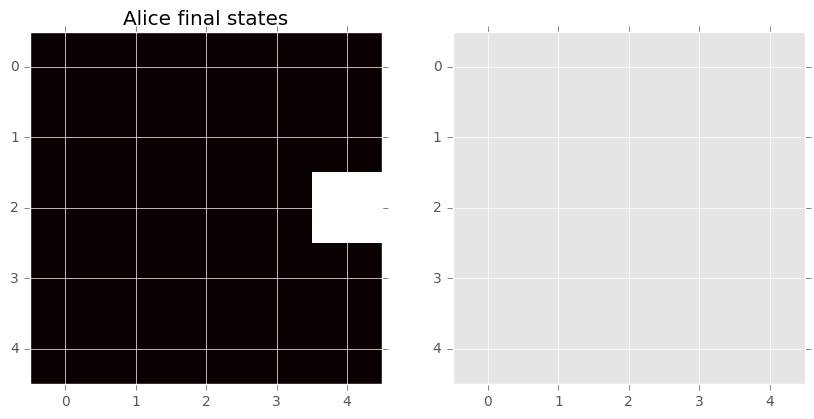

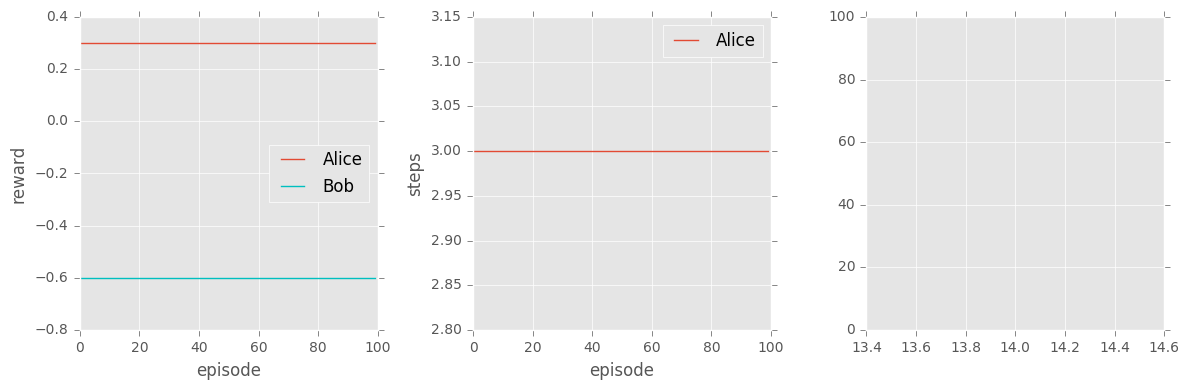

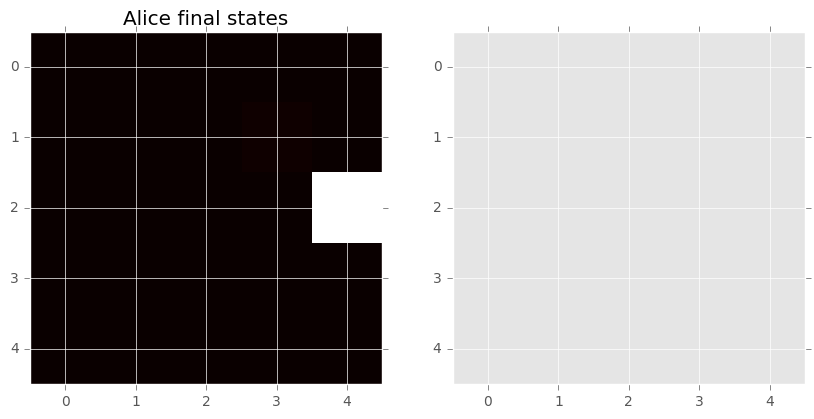

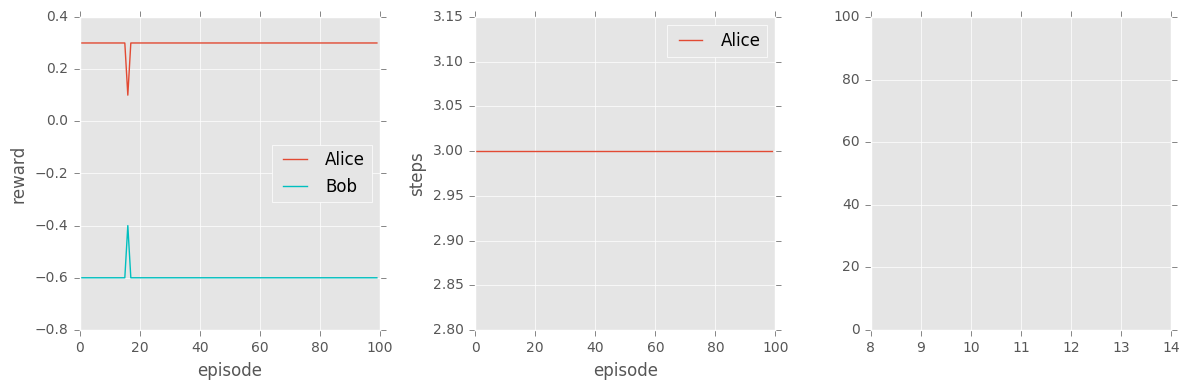

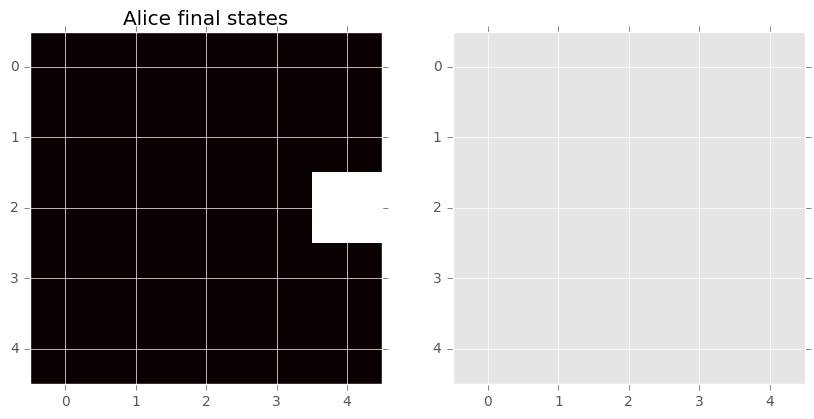

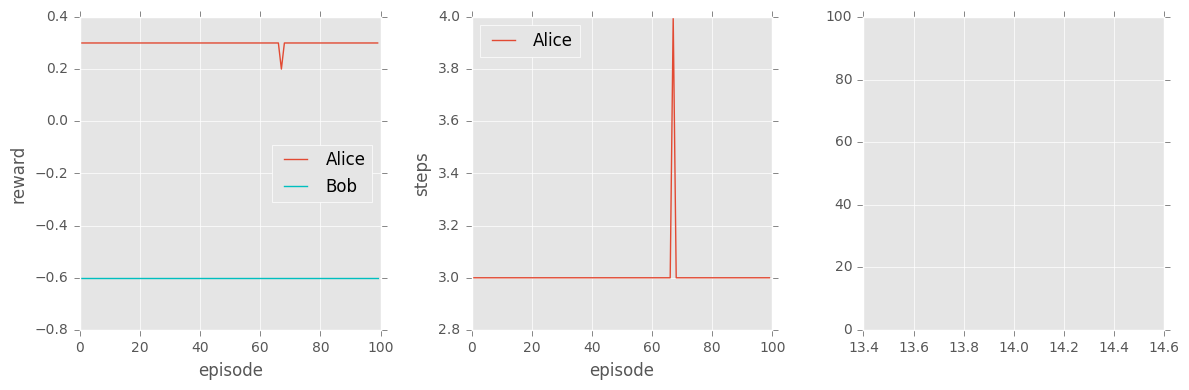

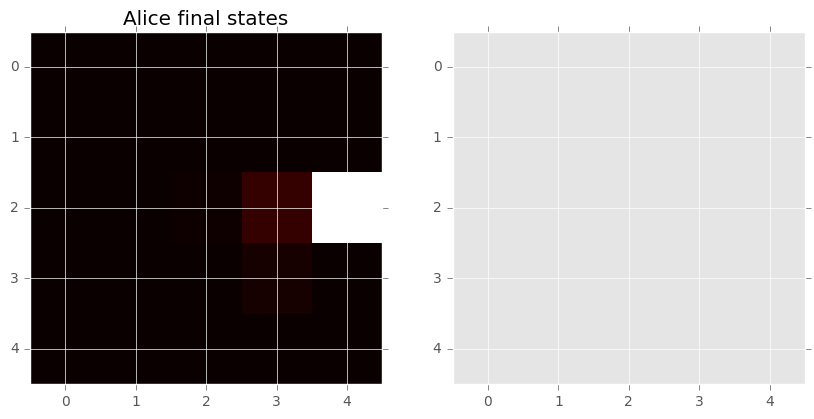

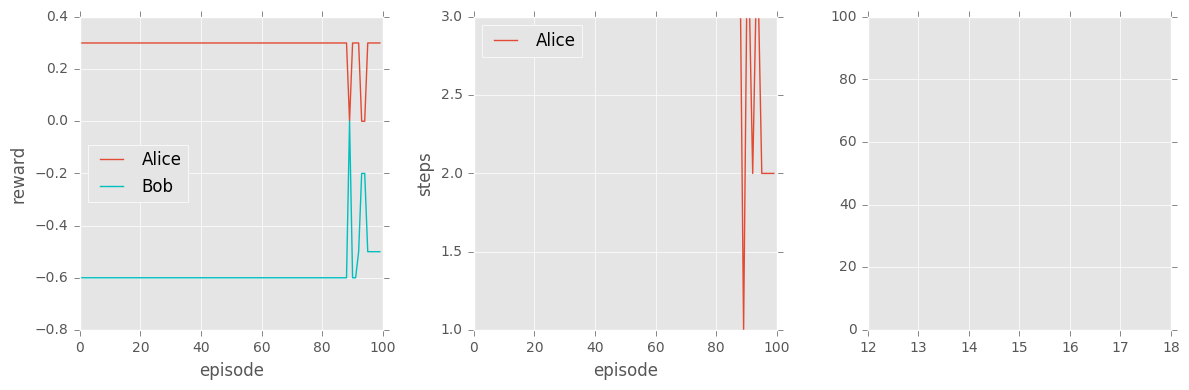

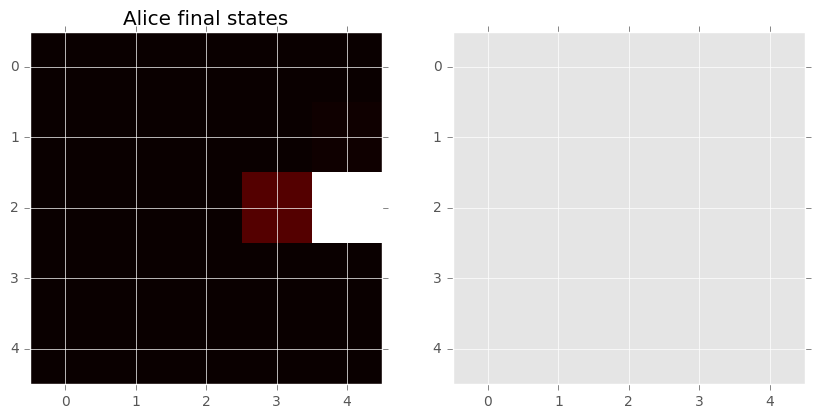

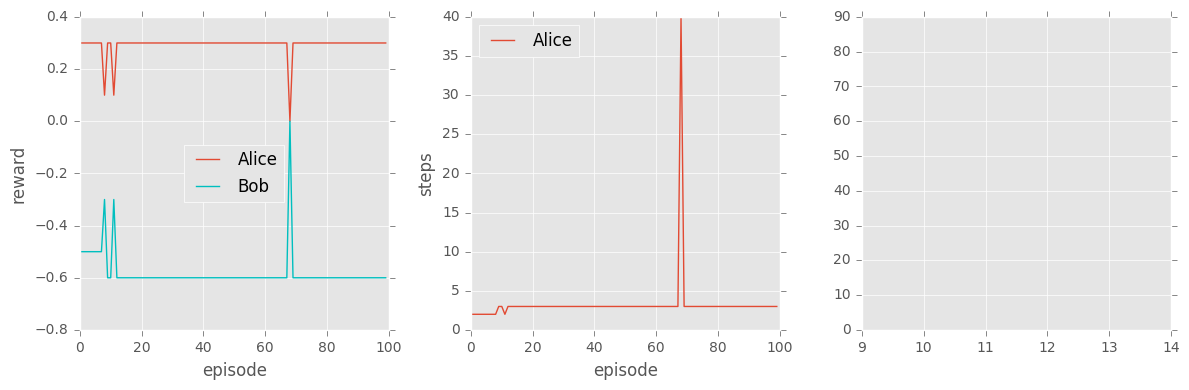

In [73]:
import matplotlib
matplotlib.style.use("ggplot")
episodes_step = 1000
times = 30
start = 0

for i in tnrange(times):
    model_Alice, model_Bob, rewards, time, finish_states = pretrain_model(env, 40, model_Alice, model_Bob, episodes_step, pretraining_type="Repeat")
    
    dense_Alice = np.zeros((5, 5))
    for finish in finish_states[:, 0]:
        dense_Alice[finish // 5][finish % 5] += 1

    dense_Bob = np.zeros((5, 5))
    for finish in finish_states[:, 1]:
        dense_Bob[finish // 5][finish % 5] += 1

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax[0].imshow(dense_Alice, cmap='hot', interpolation='nearest')
    ax[0].set_title("Alice final states")

    ax[1].imshow(dense_Bob, cmap='hot', interpolation='nearest')
    ax[1].set_title("Bob final states")
    
    plt.savefig(plots_dir + "/final_states{}".format(episodes_step * (start + i + 1)))
    plt.cla()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax[0].plot(rewards[:, 0], label="Alice")
    ax[1].plot(time[:, 0], label="Alice")

    ax[2].hist(finish_states[:, 0], alpha=0.5, label="Alice")
    ax[2].hist(finish_states[:, 1], color='c', alpha=0.5, label="Bob")
    ax[0].plot(rewards[:, 1], color='c', label="Bob")


    ax[0].set_xlabel("episode")
    ax[1].set_xlabel("episode")
    ax[1].set_ylabel("steps")
    ax[0].set_ylabel("reward")
    ax[2].set_xlabel("final state")
    ax[2].set_ylabel("distribution")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[2].legend(loc="best")
    fig.tight_layout()
    
    plt.savefig(plots_dir + "/reward_time_final{}".format(episodes_step * (start + i + 1)))
    plt.cla()

In [69]:
torch.zeros((1, 5))[0][4]

0.0

In [70]:
state = np.array([13, 4])
state = torch.from_numpy(state).float().unsqueeze(0)
probs, state_value = model_Alice_old(Variable(state))
print(probs)
print(state_value)

IndexError: When performing advanced indexing the indexing objects must be LongTensors or convertible to LongTensors

In [ ]:
state = np.array([22, 20])
state = torch.from_numpy(state).float().unsqueeze(0)
model_Bob(Variable(state))


NameError: name 'rewards' is not defined

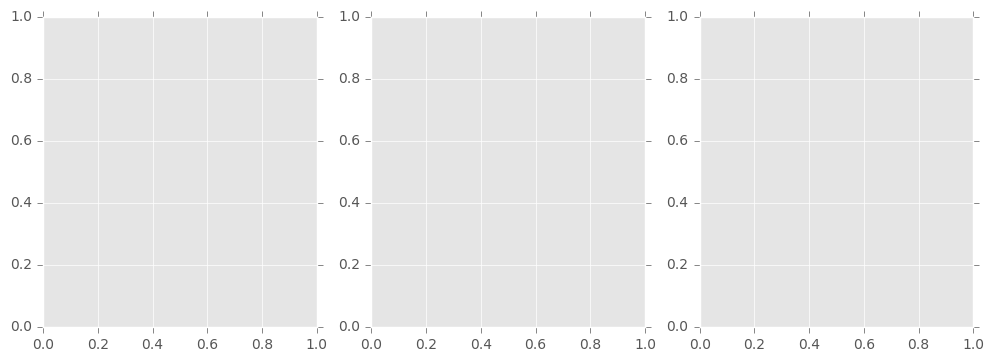

In [149]:
#10000 episodes, tmax=25, lr=1e-4, gamma=0.1
plt.style.use("ggplot")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(rewards[:, 0], label="Alice")
ax[1].plot(time[:, 0], label="Alice")

ax[2].hist(finish_states[:, 0], alpha=0.5, label="Alice")
ax[2].hist(finish_states[:, 1], color='c', alpha=0.5, label="Bob")
ax[0].plot(rewards[:, 1], color='c', label="Bob")


ax[0].set_xlabel("episode")
ax[1].set_xlabel("episode")
ax[1].set_ylabel("steps")
ax[0].set_ylabel("reward")
ax[2].set_xlabel("final state")
ax[2].set_ylabel("distribution")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
ax[2].legend(loc="best")
#ax[1][1].plot(time[:, 1], color='c')
#ax[1][2].hist(finish_states[:, 1], color='c')
fig.tight_layout()
#ax[0].subplots("Alice")
#eps = 1e-6

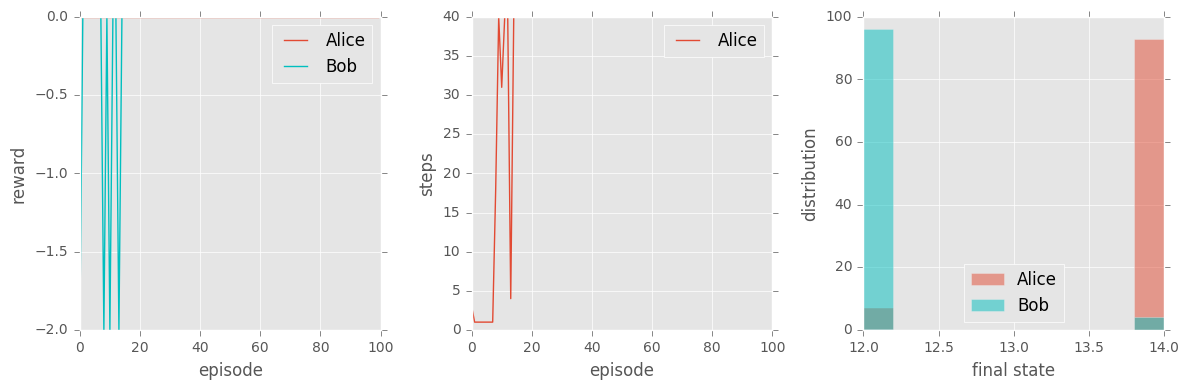

In [52]:
#10000 episodes, tmax=25, lr=1e-4, gamma=0.1
plt.style.use("ggplot")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(rewards[:, 0], label="Alice")
ax[1].plot(time[:, 0], label="Alice")

ax[2].hist(finish_states[:, 0], alpha=0.5, label="Alice")
ax[2].hist(finish_states[:, 1], color='c', alpha=0.5, label="Bob")
ax[0].plot(rewards[:, 1], color='c', label="Bob")


ax[0].set_xlabel("episode")
ax[1].set_xlabel("episode")
ax[1].set_ylabel("steps")
ax[0].set_ylabel("reward")
ax[2].set_xlabel("final state")
ax[2].set_ylabel("distribution")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
ax[2].legend(loc="best")
#ax[1][1].plot(time[:, 1], color='c')
#ax[1][2].hist(finish_states[:, 1], color='c')
fig.tight_layout()
#ax[0].subplots("Alice")
#eps = 1e-6

In [1767]:
rewards

array([[ 0. , -0. ],
       [ 0.1, -1.3],
       [ 0. , -0.4],
       [ 1.9, -2.2],
       [ 0.3, -1.4],
       [ 1.7, -2.1],
       [ 0. , -0.2],
       [ 1.9, -2.2],
       [ 0. , -0.4],
       [ 0. , -0. ],
       [ 0.7, -1.6],
       [ 0.9, -1.7],
       [ 0. , -1. ],
       [ 1.3, -1.9],
       [ 0.5, -1.5],
       [ 0.3, -1.4],
       [ 0. , -0.8],
       [ 0.9, -1.7],
       [ 0. , -0.3],
       [ 1.3, -1.9],
       [ 0. , -0.5],
       [ 2. , -2.2],
       [ 0.5, -1.5],
       [ 1.9, -2.2],
       [ 1.7, -2.1],
       [ 0. , -0.1],
       [ 2.1, -2.3],
       [ 0. , -1. ],
       [ 2.1, -2.3],
       [ 0.3, -1.4],
       [ 0. , -1. ],
       [ 0.3, -1.4],
       [ 1.5, -2. ],
       [ 0.9, -1.7],
       [ 0.9, -1.7],
       [ 1.9, -2.2],
       [ 1.9, -2.2],
       [ 0.9, -1.7],
       [ 0. , -1.2],
       [ 0.7, -0.9],
       [ 1.9, -2.2],
       [ 1.9, -2.2],
       [ 1.9, -2.2],
       [ 0. , -0. ],
       [ 1.9, -2.2],
       [ 1.9, -2.2],
       [ 0. , -0. ],
       [ 1.7,

In [ ]:
model_Bob10000, rewards10000, time, finish_states10000 = model_Bob, rewards, time, finish_states

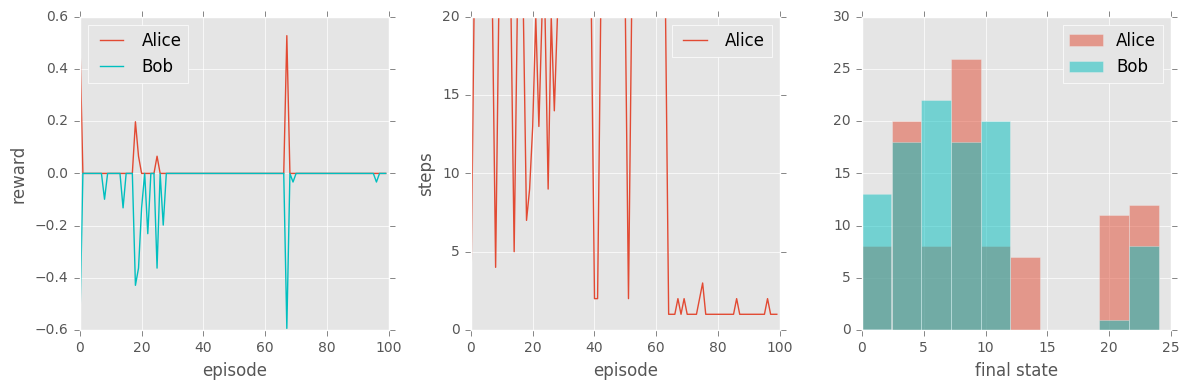

In [864]:
#1000 episodes, tmax=20, lr=1e-2
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(rewards[:, 0], label="Alice")
ax[1].plot(time[:, 0], label="Alice")
ax[2].hist(finish_states[:, 0], alpha=0.5, label="Alice")
ax[2].hist(finish_states[:, 1], color='c', alpha=0.5, label="Bob")
ax[0].plot(rewards[:, 1], color='c', label="Bob")
ax[0].set_xlabel("episode")
ax[1].set_xlabel("episode")
ax[1].set_ylabel("steps")
ax[0].set_ylabel("reward")
ax[2].set_xlabel("final state")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
ax[2].legend(loc="best")
#ax[1][1].plot(time[:, 1], color='c')
#ax[1][2].hist(finish_states[:, 1], color='c')
fig.tight_layout()
#ax[0].subplots("Alice")
#eps = 1e-6

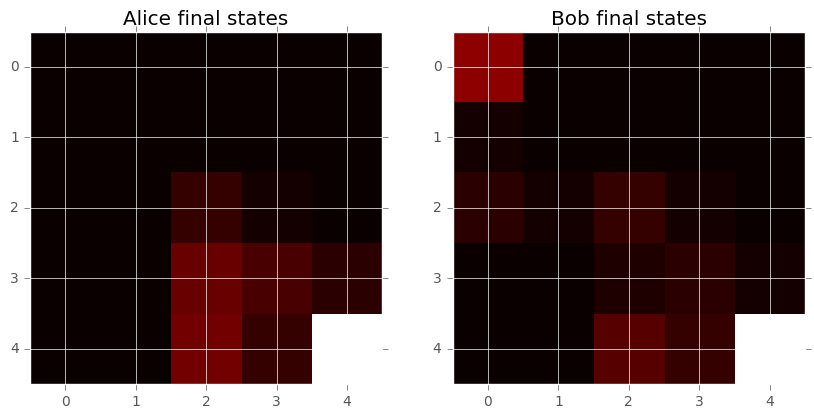

In [1973]:
dense_Alice = np.zeros((5, 5))
for finish in finish_states[:, 0]:
    dense_Alice[finish // 5][finish % 5] += 1

dense_Bob = np.zeros((5, 5))
for finish in finish_states[:, 1]:
    dense_Bob[finish // 5][finish % 5] += 1
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(dense_Alice, cmap='hot', interpolation='nearest')
ax[0].set_title("Alice final states")

ax[1].imshow(dense_Bob, cmap='hot', interpolation='nearest')
ax[1].set_title("Bob final states")

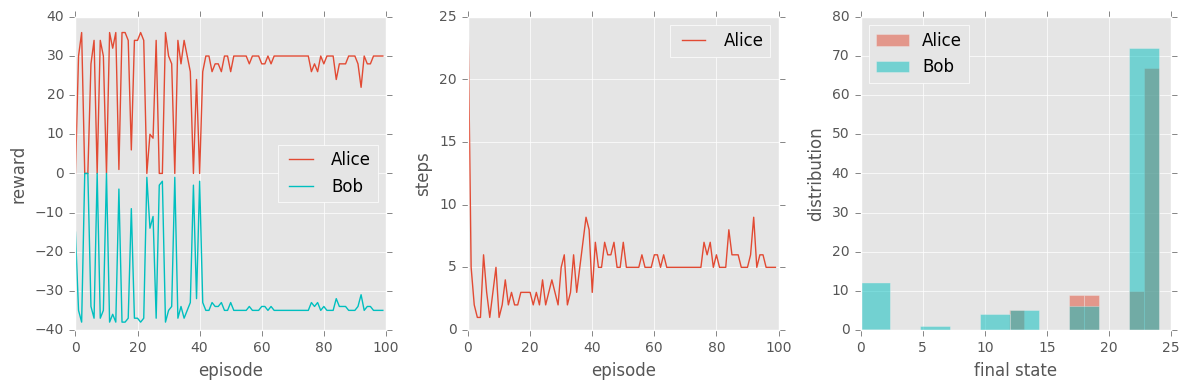

In [1974]:
#10000 episodes, tmax=40, lr=1e-3, gamma=1, lambda=0.1, rmsprop
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(rewards[:, 0], label="Alice")
ax[1].plot(time[:, 0], label="Alice")

ax[2].hist(finish_states[:, 0], alpha=0.5, label="Alice")
ax[2].hist(finish_states[:, 1], color='c', alpha=0.5, label="Bob")
ax[0].plot(rewards[:, 1], color='c', label="Bob")


ax[0].set_xlabel("episode")
ax[1].set_xlabel("episode")
ax[1].set_ylabel("steps")
ax[0].set_ylabel("reward")
ax[2].set_xlabel("final state")
ax[2].set_ylabel("distribution")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
ax[2].legend(loc="best")
#ax[1][1].plot(time[:, 1], color='c')
#ax[1][2].hist(finish_states[:, 1], color='c')
fig.tight_layout()
#ax[0].subplots("Alice")
#eps = 1e-6